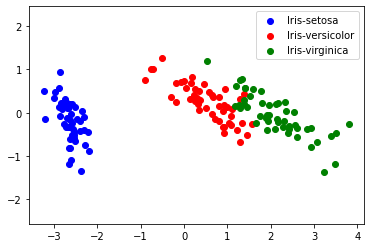

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

iris = pd.read_csv('iris.data', header=None)
train_data = iris.iloc[:,0:-1]
train_target = iris.iloc[:,-1]
def PCA(X,PC):
    mean = X.mean(0)
    A = X-mean
    u,s,vt = np.linalg.svd(A, full_matrices=True)
    return vt

x_y = np.dot(train_data-train_data.mean(0),PCA(train_data,1)[0:2,:].T)
y_number = np.array([], dtype=np.int8)
for i in range(0,len(train_target)):
    if train_target.unique()[0]==train_target[i]:
        setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')
        y_number = np.append(y_number,2)
    if train_target.unique()[1]==train_target[i]:
        versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
        y_number = np.append(y_number,0)
    if train_target.unique()[2]==train_target[i]:
        virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
        y_number = np.append(y_number,1)
plt.axis('equal')
plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.show()

the accuracy is 0.8866666666666667


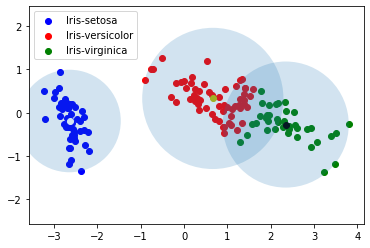

In [2]:
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from sklearn import metrics

kmean_initial = KMeans(n_clusters=3).fit(x_y)
label = kmean_initial.labels_
relabel = label.copy()
centers = kmean_initial.cluster_centers_
recenters = centers.copy()
center_ordered = np.argsort(np.argsort(np.linalg.norm(centers,axis=1)))

for i in range(len(label)):
    for j in range(3):
        if center_ordered[j]!=j:
            if label[i]==j:
                relabel[i]=center_ordered[j]
for i in range(3):
    if center_ordered[i]!=i:
        recenters[center_ordered[i]]=centers[i]

for i in range(len(label)):
    if relabel[i] == 0:
        versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
    if relabel[i] == 1:
        virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
    if relabel[i] == 2:
        setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')
def getRadius(center,j):
    radius =0
    for i in range(len(relabel)):
        if j==relabel[i]:
            r = np.linalg.norm(x_y[i]-center)
            if r>=radius:
                radius = r
    return radius
ax = plt.scatter(recenters[0,0],recenters[0,1],c='y')
ax = plt.scatter(recenters[1,0],recenters[1,1],c='k')
ax = plt.scatter(recenters[2,0],recenters[2,1],c='w')
ax = plt.axis('equal')
ax = plt.gca()
for i in range(len(recenters[:,0])):
    ax.add_patch(Circle(recenters[i,:],radius=getRadius(recenters[i,:],i), alpha=1/5))

score = 0
for i in range(len(y_number)):
    if y_number[i] == relabel[i]:
        score+=1

print('the accuracy is',score/len(y_number))

plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.show()



In [3]:
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
def initialize_random_params():
    params = {'pi0': x_y[relabel==0].shape[0]/x_y.shape[0],
              'pi1': x_y[relabel==1].shape[0]/x_y.shape[0],
              'pi2': x_y[relabel==2].shape[0]/x_y.shape[0],
              'mu0': recenters[0],
              'mu1': recenters[1],
              'mu2': recenters[2],
              'sigma0': np.cov(x_y[relabel == 0].T, bias= True),# np.identity(2), #np.cov(x_y[relabel == 0].T, bias= True),
              'sigma1': np.cov(x_y[relabel == 1].T, bias= True),#np.identity(2), #np.cov(x_y[relabel == 1].T, bias= True),
              'sigma2': np.cov(x_y[relabel == 2].T, bias= True)}#np.identity(2)} #np.cov(x_y[relabel == 2].T, bias= True)}
    return params
params=initialize_random_params()
params3=initialize_random_params()

print(params)
#def e_step(x,params):
#    log_pdf = np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
#                      multivariate_normal(params["mu1"], params["sigma1"]).pdf(x),
#                      multivariate_normal(params["mu2"], params["sigma2"]).pdf(x)])
#    log_pi_pdf = np.log([params["pi0"], params["pi1"], params["pi2"]])[np.newaxis, ...] + log_pdf.T
#    log_pi_pdf_norm = logsumexp(log_pi_pdf, axis=1)
#    r = np.exp(log_pi_pdf - log_pi_pdf_norm[..., np.newaxis])
#    return log_pi_pdf_norm,r
def E(x,params):
    pdf0 = multivariate_normal(params["mu0"], params["sigma0"]).pdf(x)*params["pi0"]
    pdf1 = multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)*params["pi1"]
    pdf2 = multivariate_normal(params["mu2"], params["sigma2"]).pdf(x)*params["pi2"]
    pdf = np.array([pdf0,pdf1,pdf2])
    norm = np.sum(pdf,axis=0)
    return norm,np.divide(pdf,norm).T

x0,r0=E(x_y,params)
print('starts here')
print(r0.T)


#x,r=e_step(x_y,params)

def m_step(x,params):
    _,r = E(x,params)
    pi = np.array([])
    mu = np.array([])
    sigma = np.array([])
    for i in range(3):
        sum_r = np.sum(r[:,i])
        pi = np.append(pi, sum_r/x.shape[0])
        #mu = np.append(mu,(r[:,i][..., np.newaxis].T.dot(x)/sum_r))
        mu = np.append(mu,r[:,i].dot(x[:,0])/sum_r)
        mu = np.append(mu,r[:,i].dot(x[:,1])/sum_r)
        difference = (x-mu[i:i+2])
        #sigma = np.append(sigma,difference.T.dot(difference*r[:,i][..., np.newaxis])/sum_r)
        sigma = np.append(sigma,(r[:,i].reshape(150,1,1)*(difference[:,:,None] * difference[:,None,:])).sum(axis = 0)/sum_r)
        #diff0.T.dot(diff0 * heuristic0[..., np.newaxis])
        #sigma = np.append(sigma,(x-mu[i:i+2]).T.dot((x-mu[i:i+2])*r[:,i][:,np.newaxis])/sum_r)
    params = {'pi0':pi[0],'pi1':pi[1],'pi2':pi[2],'mu0':mu[0:2],'mu1':mu[2:4],'mu2':mu[4:6],\
              'sigma0':sigma[0:4].reshape((2,2)),'sigma1':sigma[4:8].reshape((2,2)),\
              'sigma2':sigma[8:12].reshape((2,2))}
    return params
x = x_y-centers[0]
params2=m_step(x_y,params)



{'pi0': 0.4066666666666667, 'pi1': 0.26, 'pi2': 0.3333333333333333, 'mu0': array([0.66443351, 0.33029221]), 'mu1': array([ 2.34645113, -0.27235455]), 'mu2': array([-2.64084076, -0.19051995]), 'sigma0': array([[ 0.3777503 , -0.10985456],
       [-0.10985456,  0.14495779]]), 'sigma1': array([[ 0.35155689, -0.10572859],
       [-0.10572859,  0.13213395]]), 'sigma2': array([[ 0.04777048, -0.05590782],
       [-0.05590782,  0.21472356]])}
starts here
[[1.59021958e-012 5.64531244e-010 6.74348300e-011 2.01505753e-009
  9.24028352e-013 1.39211487e-012 6.43796262e-011 2.46581025e-011
  6.89161439e-009 4.49437652e-010 1.46491226e-013 2.05516011e-010
  4.81288452e-010 6.15375779e-010 1.13547472e-017 1.28325706e-017
  3.27213085e-015 2.62328148e-012 7.94205654e-013 3.43130383e-013
  1.88316670e-010 1.90277906e-012 1.55213484e-012 1.76995062e-008
  4.02637626e-008 8.94681337e-009 4.21713254e-010 3.65905437e-012
  2.89414143e-012 2.23004560e-009 4.83725698e-009 2.11388001e-011
  2.51373215e-015 6.16

In [4]:

print("unsupervised: ")
params2 = initialize_random_params()
#unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_y, params)
def EM(x, params, n):
    for i in range(n):
        params = m_step(x, params)
        print(params['pi0'],params['pi1'],params['pi2'])
    print("pi0: %s\npi1: %s\npi2: %s\nmu_0: %s\nmu_1: %s\nmu_2: %s\nsigma0: %s\nsigma1: %s\nsigma2: %s"
          % (params['pi0'],params['pi1'],params['pi2'],params['mu0'],params['mu1'],params['mu2'],params['sigma0'],params['sigma1'],params['sigma2'],))
    _,r= E(x, params)
    forecasts = np.argmax(r, axis=1)
    params = m_step(x, params)
    return params, r, n

#unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = EM(x_y, params2,0)


"""print("total steps: ", unsupervised_loglikelihoods)
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.show()
plt.close()"""

unsupervised: 


'print("total steps: ", unsupervised_loglikelihoods)\nplt.plot(unsupervised_loglikelihoods)\nplt.title("unsupervised log likelihoods")\nplt.show()\nplt.close()'

0.4134677765529026 0.25319889319473277 0.3333333302523646
pi0: 0.4134677765529026
pi1: 0.25319889319473277
pi2: 0.3333333302523646
mu_0: [0.71470631 0.29662735]
mu_1: [ 2.30953702 -0.23356816]
mu_2: [-2.64084076 -0.19051996]
sigma0: [[ 0.44814561 -0.14434496]
 [-0.14434496  0.1643513 ]]
sigma1: [[ 4.48238944 -5.27885458]
 [-5.27885458  6.62065355]]
sigma2: [[24.55401058 -0.26901265]
 [-0.26901265  0.2165767 ]]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 2 0 1 1 1 0
 0 1 1 0 0 0 1 2 0 1 0 2 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0
 0 0]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

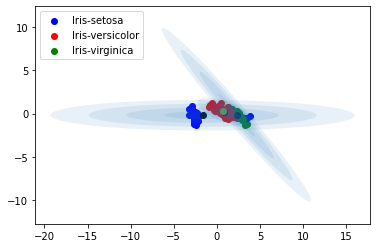

[[ 0.3777503  -0.10985456]
 [-0.10985456  0.14495779]] [[ 0.35155689 -0.10572859]
 [-0.10572859  0.13213395]] [[ 0.04777048 -0.05590782]
 [-0.05590782  0.21472356]]
[[ 0.66443351  0.33029221]
 [ 2.34645113 -0.27235455]
 [-2.64084076 -0.19051995]]


In [5]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
params=0
params, unsupervised_posterior, unsupervised_loglikelihoods = EM(x_y, params2,1)
predicted = np.array([], dtype=np.int8)
for i in range(unsupervised_posterior.shape[0]):
    index = np.argmax(unsupervised_posterior[i])
    if index ==0:
        reshuffle = 2
    if index ==1:
        reshuffle =0
    if index ==2:
        reshuffle =1
    predicted = np.append(predicted,index)
print(predicted)
print(y_number)
print(x_y.shape)
score = 0
for i in range(len(y_number)):
    if y_number[i] == predicted[i]:
        score+=1
print(score/150)
for i in range(len(predicted)):
    if predicted[i] == 0:
        versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
    if predicted[i] == 1:
        virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
    if predicted[i] == 2:
        setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')
elipse_centers = np.array([params['mu0'],params['mu1'],params['mu2']])
covariance = np.array([params['sigma0'],params['sigma1'],params['sigma2']])
bx = plt.scatter(elipse_centers[:,0],elipse_centers[:,1],c='k')
bx = plt.axis('equal')
bx = plt.scatter(recenters[0,0],recenters[0,1],c='y')
bx = plt.gca()
for i in range(3):
    draw_ellipse(elipse_centers[i],covariance[i],alpha=1/10)
#draw_ellipse()
#draw_ellipse()
#draw_ellipse()
plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.show()
print(params2['sigma0'],params2['sigma1'],params2['sigma2'])
print(recenters)
